In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.neural_network import MLPClassifier
import matplotlib.pylab as plt

from utilities import *

DATA = Path('.').resolve().parent / 'data'

In [2]:
fundraising_df = pd.read_csv(DATA/'Fundraising.csv')
fundraising_df.drop(columns = ['Row Id', 'Row Id.'], inplace = True)
fundraising_df.columns = [s.strip().replace(' ', '_') for s in fundraising_df.columns]
fundraising_df.TARGET_B = fundraising_df.TARGET_B.astype('category')
train_df = fundraising_df.sample(frac=0.6, random_state=12345)
valid_df = fundraising_df.drop(train_df.index)

When classes are present in very unequal proportions, simple random sampling may produce too few of the rare class to yield useful information that will distinguish them from the dominant class. In this fundraising data, the actual response rate is 5.1% comparing to the other class 94.9%. To improve the performance of classifiers, weighted sampling is used so that the sample will have similar number of each class.

We run logistic classification on the data, with first 10 columns as independent variables, TARGET_B as response.

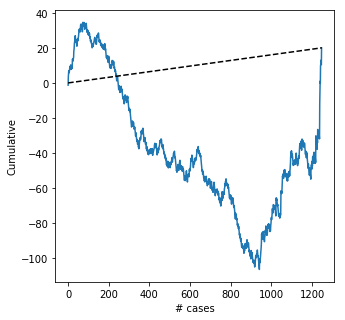

In [4]:
logit_reg = sm.GLM(train_df['TARGET_B'], train_df.drop(columns=['TARGET_B','TARGET_D']), family=sm.families.Binomial())
logit_result = logit_reg.fit()
y_valid_logit = pd.concat([valid_df.reset_index(drop=True), 
                           pd.DataFrame(logit_result.predict(valid_df.drop(columns=['TARGET_B','TARGET_D'])), 
                                        columns=['donor']).reset_index(drop=True)], axis=1).iloc[:,20:23]
y_valid_logit.loc[y_valid_logit.TARGET_B == 1, 'netprofit'] = (y_valid_logit.TARGET_D-0.68)/9.8
y_valid_logit.loc[y_valid_logit.TARGET_B == 0, 'netprofit'] = (y_valid_logit.TARGET_D-0.68)/0.53
y_valid_logit = y_valid_logit.sort_values(by=['donor'], ascending=False).reset_index(drop=True)
lift_df = pd.DataFrame({'numberMailed': [i for i in range(len(y_valid_logit))],'cumProfit': y_valid_logit.netprofit.cumsum()})

ax = lift_df.plot(x='numberMailed', y='cumProfit', legend=False, figsize=[5, 5])
ax.plot([0, len(y_valid_logit)], [0, y_valid_logit.netprofit.sum()], linestyle='--', color='k')
ax.set_xlabel('# cases')
ax.set_ylabel('Cumulative')
plt.show()

We run Neural Network on the data, with first 10 columns as independent variables, TARGET_B as response. Single layer with 2 nodes.

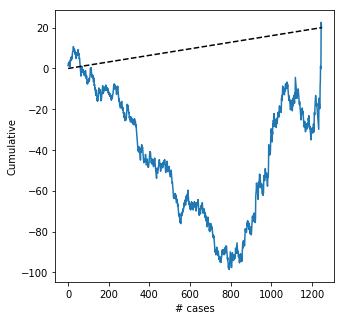

In [5]:
scaleInput = MinMaxScaler()
scaleInput.fit(train_df.drop(columns=['TARGET_B','TARGET_D']))
labelOutput = LabelEncoder()
labelOutput.fit(train_df['TARGET_B'])

X = scaleInput.transform(train_df.drop(columns=['TARGET_B','TARGET_D']))
y = labelOutput.transform(train_df['TARGET_B'])

clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs', verbose=True, random_state=12345)
clf.fit(X, y)
X_valid = scaleInput.transform(valid_df.drop(columns=['TARGET_B','TARGET_D']))
y_valid = pd.concat([valid_df.reset_index(drop=True), 
           pd.DataFrame(clf.predict_proba(X_valid), columns=['non-donor', 'donor'])], 
                    axis=1).iloc[:,20:24]
y_valid.loc[y_valid.TARGET_B == 1, 'netprofit'] = (y_valid.TARGET_D-0.68)/9.8
y_valid.loc[y_valid.TARGET_B == 0, 'netprofit'] = (y_valid.TARGET_D-0.68)/0.53
y_valid = y_valid.sort_values(by=['donor'], ascending=False).reset_index(drop=True)
lift_df = pd.DataFrame({'numberMailed': [i for i in range(len(y_valid))],'cumProfit': y_valid.netprofit.cumsum()})

ax = lift_df.plot(x='numberMailed', y='cumProfit', legend=False, figsize=[5, 5])
ax.plot([0, len(y_valid)], [0, y_valid.netprofit.sum()], linestyle='--', color='k')
ax.set_xlabel('# cases')
ax.set_ylabel('Cumulative')
plt.show()

From the above analysis, logistic classification is a better choice for this case, We can see from the net profit lift curve that the high probability has better prediction.

In [6]:
future_df = pd.read_csv(DATA/'FutureFundraising.csv')
future_df.drop(columns = ['Row Id'], inplace = True)
future_df.columns = [s.strip().replace(' ', '_') for s in future_df.columns]
future_df.shape

(3210, 20)

In [7]:
y_test_logit = pd.concat([future_df.reset_index(drop=True), 
                           pd.DataFrame(logit_result.predict(future_df), 
                                        columns=['donor']).reset_index(drop=True)], axis=1)
y_test_logit = y_test_logit.sort_values(by=['donor'], ascending=False).reset_index(drop=True)
y_test_logit.head()

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner_dummy,NUMCHLD,INCOME,gender_dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,donor
0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,0.0,8.0,4799.0,...,595.0,4.0,87.0,604.0,30.0,0.0,18.0,6.0,19.483871,0.876989
1,1.0,0.0,0.0,0.0,1.0,1.0,7.0,1.0,9.0,2614.0,...,678.0,4.0,65.0,118.0,25.0,10.0,19.0,25.0,14.750000,0.861819
2,0.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,6.0,4291.0,...,419.0,9.0,48.0,128.0,25.0,5.0,17.0,4.0,10.666667,0.855026
3,0.0,0.0,0.0,1.0,0.0,1.0,5.0,1.0,9.0,3621.0,...,577.0,6.0,102.0,202.0,14.0,13.0,17.0,11.0,10.100000,0.842940
4,1.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,9.0,1651.0,...,429.0,9.0,108.0,169.0,11.0,5.0,18.0,13.0,6.259259,0.841896


In [8]:
mails = y_test_logit.loc[y_test_logit.donor > 0.65].shape[0]
print('If we cut at P(donor=1) great than 0.65, number of mails = ', mails)

If we cut at P(donor=1) great than 0.65, number of mails =  150
